In [3]:
from resources.AIRMODE.load_helpers import *
import matplotlib.pyplot as plt

## Problem

Given a data set of empirical frequencies $\mathcal{D}^{emp} = \{y_i\}_i^{N_{emp}},$ collected from a real system and digital replica $y = M(\theta),$ calibrate a model for the uncertain parameters $\theta$, e.g., a probability density function $f_\theta(\theta|\mathcal{D}, M)$ conditional to the knowledge and information and data available.


We use here the AIRMOD use case for model calibration adapted from https://doi.org/10.1016/j.ymssp.2024.111440
A surrogate neural network $M(\theta)$ trained to map the input $\theta \in \Theta \subset \mathbb{R}^{11}$ to 10 output frequencies

$$y = (D_{1},..., D_{10})$$

## Solution approach

* We will generate a data set of simulated input-outputs using the surrogate network $\mathcal{D}_0^{sim} = \{\theta_i, M(\theta_i)\}_i^{N^{(0)}_{sim}}$

* We identify K nearest input-output pairs to each sample in $\mathcal{D}^{emp}$, and obtain a set of post plausible inputs $ \mathcal{D}^{knn} = \{\theta_i, M(\theta_i)\}_i^{N_{emp}\times K }$

* We will re-sample $\mathcal{D}_q^{sim} = \{\theta_j, M(\theta_j)\}_i^{N^{(1)}_{sim}}$ where $\theta_j \sim N(\theta,\Sigma))  \forall \theta\in \mathcal{D}_0^{sim}$


Now we will be preparing names paths and finally load the simulated data

In [4]:
# ---------- Paths ----------
sim_data_path_2M = Path("resources/AIRMODE/airmod_io_repo_style.csv") # path with 2M simulations
sim_data_path = Path("resources/AIRMODE/airmod_io_repo_style_500k.csv")  #
emp_data_path = Path("resources/AIRMODE/data/DLRAirmodData.mat")
ref_tmcmc_data_path = Path("resources/AIRMODE/data/reference_TMCMC_DLRAirmod.mat")

# ---------- input-output names
theta_names = [  "theta1_front_bungee_k",     "theta2_rear_bungee_k",   "theta3_vtp_k",               "theta4_tail_joint_m",
                 "theta5_right_wingtip_m",     "theta6_left_wingtip_m",  "theta7_rl_wingtip_add_m",    "theta8_outer_wing_add_m",
                 "theta9_wf_joint_k_x",        "theta10_wf_joint_k_y",  "theta11_wf_joint_k_z" ]

theta_latex_names = [ r"$\theta_1$",  r"$\theta_2$", r"$\theta_3$",    r"$\theta_4$",  r"$\theta_5$", r"$\theta_6$",
                      r"$\theta_7$",  r"$\theta_8$", r"$\theta_9$",   r"$\theta_{10}$",  r"$\theta_{11}$"]

y_cols = ['D1_roll', 'D2_pitch', 'D3_heave', 'D4_2ndEF_bend', 'D5_3rdEF_bend',  'D6_antisym_tors', 'D7_sym_tors',  'D8_vtp_bend', 'D9_4thEF_bend', 'D10_1stEF_foreaft']
Y_latex_names = [ r"$D_1$",  r"$D_2$", r"$D_3$",  r"$D_4$",  r"$D_5$", r"$D_6$",   r"$D_7$",  r"$D_8$", r"$D_9$",   r"$D_{10}$"]

# ---------- Load & extract TMCMC
tmobj = load_mat_any(str(ref_tmcmc_data_path))
theta_tmcmc, src_path = find_theta_matrix_from_mat(tmobj)
print(f"[TMCMC] extracted from '{src_path}' -> {theta_tmcmc.shape}")

# --------------------------- load empirical outputs ---------------------------
m = load_mat_auto(emp_data_path)
emp_key = 'artificialDataWide' if 'artificialDataWide' in m else 'artificialData'
Y_emp = np.array(m[emp_key], dtype=np.float32)  # expected shape (N_emp, 10)
print(f"[EMPIRICAL] Y_emp (from {emp_data_path}) ->  {Y_emp.shape} ")

# --------------------------- load simulated I/O ---------------------------
df = pd.read_csv(sim_data_path)
theta_scaled_cols = [c for c in df.columns if c.endswith("_scaled")]
theta_phys_cols   = [c for c in df.columns if c.endswith("_phys")]
theta_standard_normal_cols   = [c for c in df.columns if c.endswith("_znorm")]
print(f"[SIMUATED IO] df_sim {df.shape} (from {sim_data_path})")
# --------------------------- preparing arrays  ---------------------------
X_scaled = df[theta_scaled_cols].to_numpy(dtype=np.float32)   # (N, 11) in [0.2,1.8]
X_phys   = df[theta_phys_cols].to_numpy(dtype=np.float32)     # (N, 11)
X_normal   = df[theta_standard_normal_cols].to_numpy(dtype=np.float32)     # (N, 11)
Y_sim    = df[y_cols].to_numpy(dtype=np.float32)
print(f"[SIMUATED Input] X_scaled {X_scaled.shape} -> Uniform[0.2,1.8]") # <- this is the input of the DLNetwork surrogate see Matlab !!
print(f"[SIMUATED Input] X_phys {X_phys.shape} -> Uniform[min,max]")
print(f"[SIMUATED Input] X_normal {X_normal.shape}-> Normal[mean=0,std=1]")
print(f"[SIMUATED Output] Y_sim {Y_sim.shape}")

[TMCMC] extracted from 'root.tmcmcSamples_reference' -> (100000, 11)
[EMPIRICAL] Y_emp (from examples\AIRMODE\data\DLRAirmodData.mat) ->  (50, 10) 
[SIMUATED IO] df_sim (500000, 45) (from examples\AIRMODE\airmod_io_repo_style_500k.csv)
[SIMUATED Input] X_scaled (500000, 11) -> Uniform[0.2,1.8]
[SIMUATED Input] X_phys (500000, 11) -> Uniform[min,max]
[SIMUATED Input] X_normal (500000, 12)-> Normal[mean=0,std=1]
[SIMUATED Output] Y_sim (500000, 10)


* visualize the distribution of simulated output Y_sim vs Y_emp, the empirical frequencies (from the real system)

* visualize the distribution of simulated input X vs theta_tmcmc, the target (unknown)

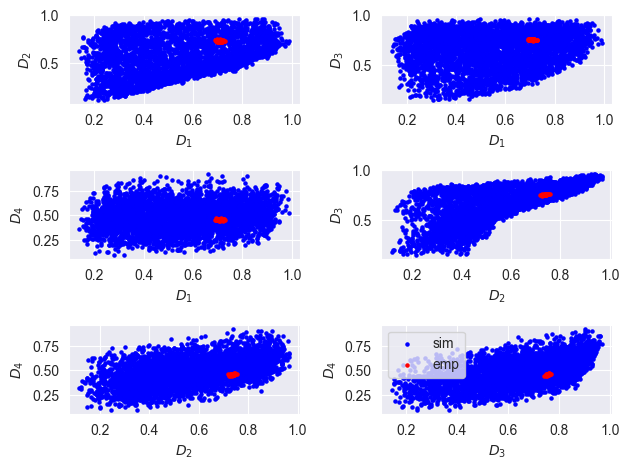

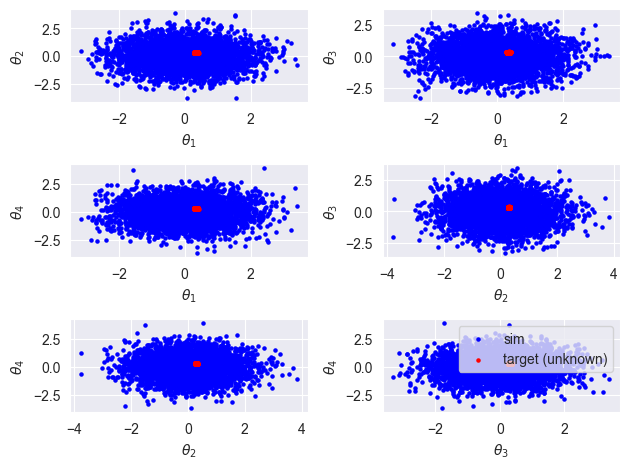

In [5]:
pairs_2_plt = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

fix, ax = plt.subplots(3,2)
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    ax.scatter(Y_sim[:4_000,pairs[0]], Y_sim[:4_000,pairs[1]], 5, c='b', label='sim')
    ax.scatter(Y_emp[:,pairs[0]], Y_emp[:,pairs[1]], 5, c='r', label='emp')
    ax.set_xlabel(Y_latex_names[pairs[0]])
    ax.set_ylabel(Y_latex_names[pairs[1]])
plt.legend()
plt.tight_layout()
plt.show()

### PLOTTING THE INPUT AND THE REFERENCE

fix, ax = plt.subplots(3,2)
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    ax.scatter(X_normal[:4_000,pairs[0]], X_normal[:4_000,pairs[1]], 5, c='b', label='sim')
    ax.scatter(theta_tmcmc[:,pairs[0]], theta_tmcmc[:,pairs[1]], 5, c='r', label='target (unknown)')
    ax.set_xlabel(theta_latex_names[pairs[0]])
    ax.set_ylabel(theta_latex_names[pairs[1]])
plt.legend()
plt.tight_layout()
plt.show()



In [6]:
X_selected = X_normal

# fit standard scaler on the outputs responses
scaler = StandardScaler()
scaler.fit(Y_sim)


N_knn = 100
neigh = NearestNeighbors(n_neighbors=N_knn)
neigh.fit(scaler.transform(Y_sim))
dist, knn_idx = neigh.kneighbors(scaler.transform(Y_emp))
theta_set = np.vstack([X_selected[idx] for idx in knn_idx])
Y_sim_knn = np.vstack([Y_sim[idx] for idx in knn_idx])
theta_set_for_resampling = np.vstack([X_scaled[idx] for idx in knn_idx]) #<-- to be resampled and fed to the DLNetwork surrogate

In [7]:
save_again = False
if save_again:
    theta_knn_set = np.unique(theta_set_for_resampling,axis=0)
    print(f" shape knn calibrated ->{np.shape(theta_knn_set)}")
    pd.DataFrame(theta_knn_set).to_csv(f'airmod_knn{N_knn}_theta_posterior.csv', index=False)
    print("Saved 1st pass: airmod_knn_theta_posterior.csv")

In [8]:
# --------------------------- load simulated I/O ---------------------------
re_sampled_knn_data_path = Path("resources/AIRMODE/airmod_io_knn_resampled.csv") # first pass knn =100  -> resampled -> N_per_sam = 250
df_resampled = pd.read_csv(re_sampled_knn_data_path)

theta_scale_cols_knn_res = [c for c in df_resampled.columns if c.endswith("_scaled_knn_resampled")]
theta_phys_cols_knn_res   = [c for c in df_resampled.columns if c.endswith("_phys_knn_resampled")]
theta_standard_normal_cols   = [c for c in df_resampled.columns if c.endswith("_znorm_knn_resampled")]


# --------------------------- preparing arrays  ---------------------------
X_scaled_knn_resampled  = df_resampled[theta_scale_cols_knn_res].to_numpy(dtype=np.float32)   # (N, 11) in [0.2,1.8]
X_phys_knn_resampled    = df_resampled[theta_phys_cols_knn_res].to_numpy(dtype=np.float32)     # (N, 11)
X_normal_knn_resampled    = df_resampled[theta_standard_normal_cols].to_numpy(dtype=np.float32)     # (N, 11)
Y_sim_knn_resampled     = df_resampled[y_cols].to_numpy(dtype=np.float32)

print(f"[SIMUATED Input] X_normal_knn_resampled {X_normal_knn_resampled.shape} ->  This uses k-nearest neighbors to estimate a covariance for each base sample and samples from N(base, alpha^2 * Cov_local + jitter*I)")
print(f"[SIMUATED Input] X_phys_knn_resampled {X_phys_knn_resampled.shape} -> rescaled on the physical space")
print(f"[SIMUATED Input] X_normal_knn_resampled {X_normal_knn_resampled.shape} -> rescaled on the physical space")
print(f"[SIMUATED Output] Y_sim {Y_sim_knn_resampled.shape}")

[SIMUATED Input] X_normal_knn_resampled (426000, 11) ->  This uses k-nearest neighbors to estimate a covariance for each base sample and samples from N(base, alpha^2 * Cov_local + jitter*I)
[SIMUATED Input] X_phys_knn_resampled (426000, 11) -> rescaled on the physical space
[SIMUATED Input] X_normal_knn_resampled (426000, 11) -> rescaled on the physical space
[SIMUATED Output] Y_sim (426000, 10)


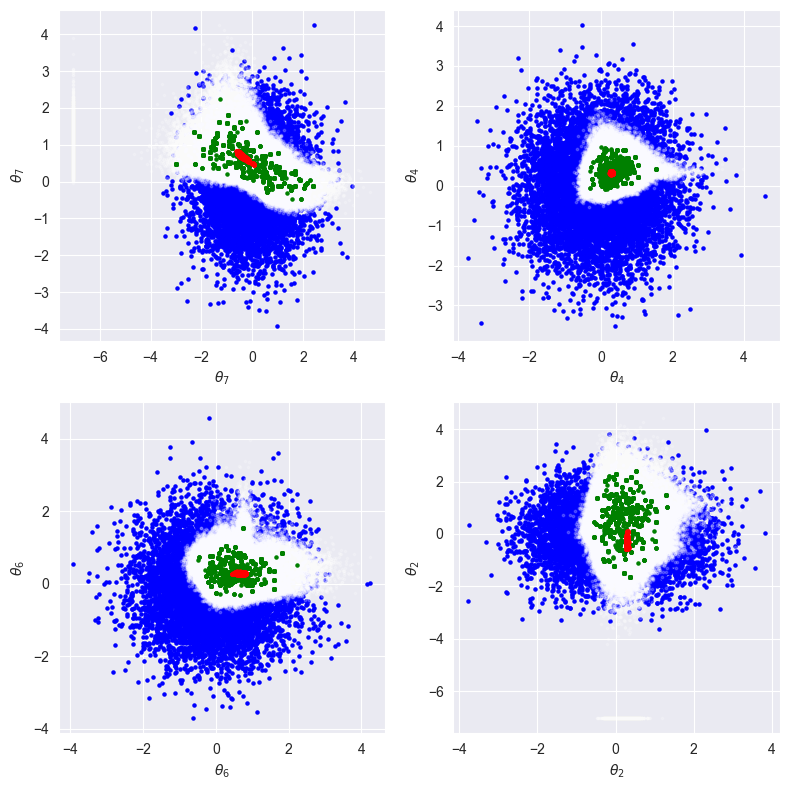

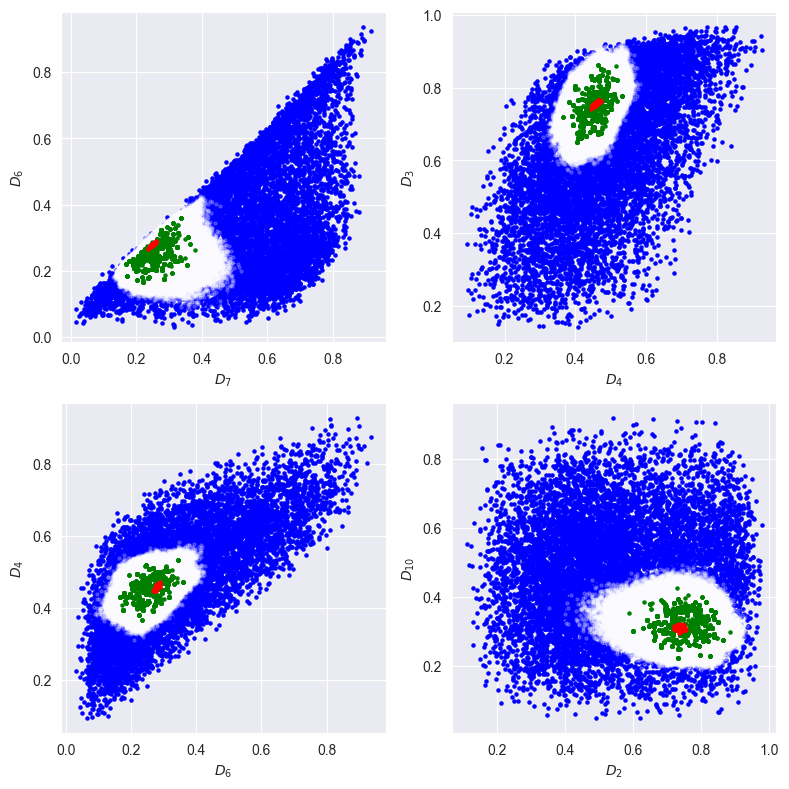

In [9]:

### PLOTTING THE INPUT AND THE REFERENCE
pairs_2_plt = [[6,5], [3,2],  [5,3], [1,9] ]
n2plt = 10_000
fix, ax = plt.subplots(2,2, figsize=(8,8))
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    ax.scatter(X_normal[:n2plt,pairs[0]], X_normal[:n2plt,pairs[1]], 5, c='b', label='sim')
    ax.scatter(X_normal_knn_resampled[: ,pairs[0]], X_normal_knn_resampled[: ,pairs[1]], 3, alpha=0.2, c='w', label='sim - knn resampled')
    ax.scatter(theta_set[:n2plt,pairs[0]], theta_set[:n2plt,pairs[1]], 5, c='g', label='knn')
    ax.scatter(theta_tmcmc[:n2plt,pairs[0]], theta_tmcmc[:n2plt,pairs[1]], 5, c='r', label='target')
    ax.set_xlabel(theta_latex_names[pairs[0]])
    ax.set_ylabel(theta_latex_names[pairs[0]])
plt.tight_layout()
plt.show()

fix, ax = plt.subplots(2,2, figsize=(8,8))
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    ax.scatter(Y_sim[:n2plt,pairs[0]], Y_sim[:n2plt,pairs[1]], 5, c='b', label='sim')
    ax.scatter(Y_sim_knn_resampled[:,pairs[0]], Y_sim_knn_resampled[:,pairs[1]], 5, alpha=0.2, c='w', label='re-sim - knn2')
    ax.scatter(Y_sim_knn[:,pairs[0]], Y_sim_knn[:,pairs[1]], 5, c='g', label='knn 0')
    ax.scatter(Y_emp[:,pairs[0]], Y_emp[:,pairs[1]], 5, c='r', label='emp')
    ax.set_xlabel(Y_latex_names[pairs[0]])
    ax.set_ylabel(Y_latex_names[pairs[1]])

plt.tight_layout()
plt.show()

In [10]:
# union of uniform + resampled knn
X_extended = np.vstack([X_normal[:,:11],X_normal_knn_resampled])
Y_extended = np.vstack([Y_sim,Y_sim_knn_resampled])

In [11]:
# union of simulated input outputs including new simulation
X_selected, Y_selected = X_extended, Y_extended
N_knn = 100
neigh = NearestNeighbors(n_neighbors=N_knn)
neigh.fit(scaler.transform(Y_selected))
_, knn_idx2 = neigh.kneighbors(scaler.transform(Y_emp))
theta_set_2 = np.vstack([X_selected[idx] for idx in knn_idx2])
Y_calibrated_knn_2  = np.vstack([Y_selected[idx] for idx in knn_idx2])



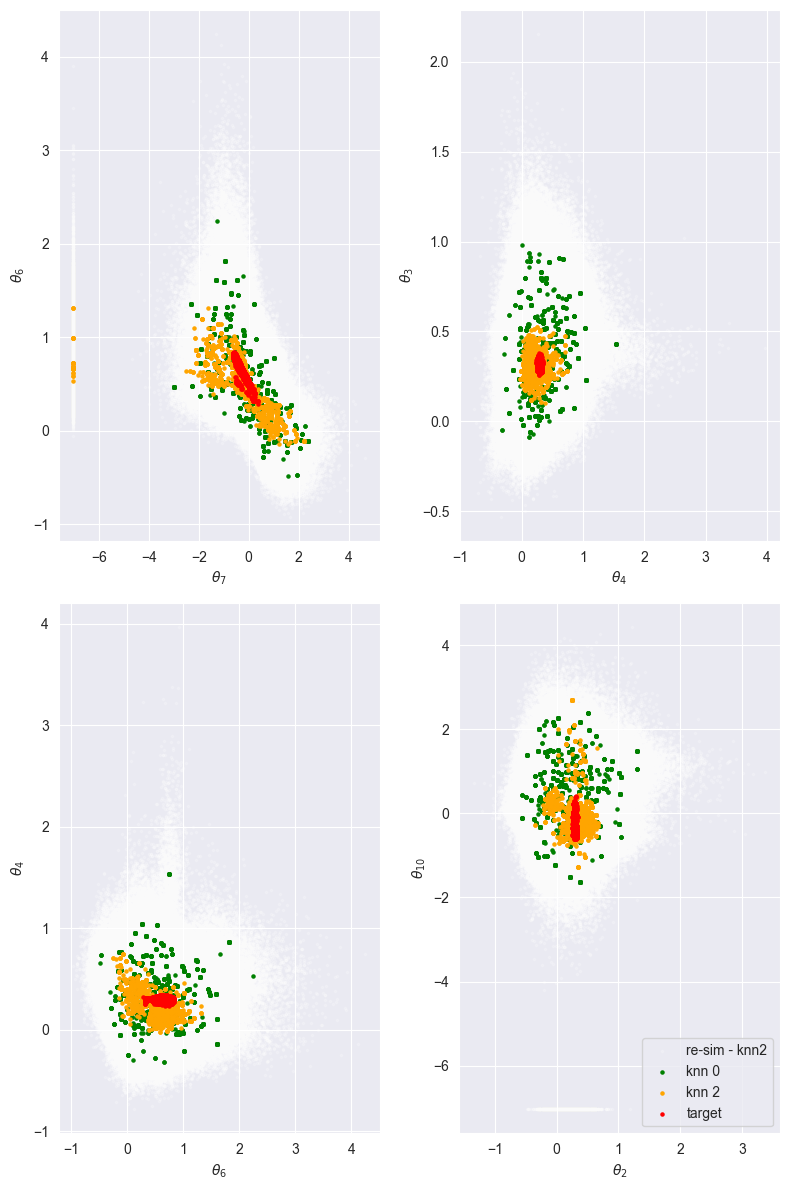

In [12]:

fix, ax = plt.subplots(2,2, figsize=(8,12))
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    # ax.scatter(X_normal[:4_000,pairs[0]], X_normal[:4_000,pairs[1]], 5, c='b', label='sim')
    ax.scatter(X_normal_knn_resampled[: ,pairs[0]], X_normal_knn_resampled[: ,pairs[1]], 3, alpha=0.2, c='w', label='re-sim - knn2')
    ax.scatter(theta_set[:,pairs[0]], theta_set[:,pairs[1]], 5, c='g', label='knn 0')
    ax.scatter(theta_set_2[:,pairs[0]], theta_set_2[:,pairs[1]], 5, c='orange', label='knn 2')
    ax.scatter(theta_tmcmc[:,pairs[0]], theta_tmcmc[:,pairs[1]], 5, c='r', label='target')
    ax.set_xlabel(theta_latex_names[pairs[0]])
    ax.set_ylabel(theta_latex_names[pairs[1]])
plt.legend()
plt.tight_layout()
plt.show()



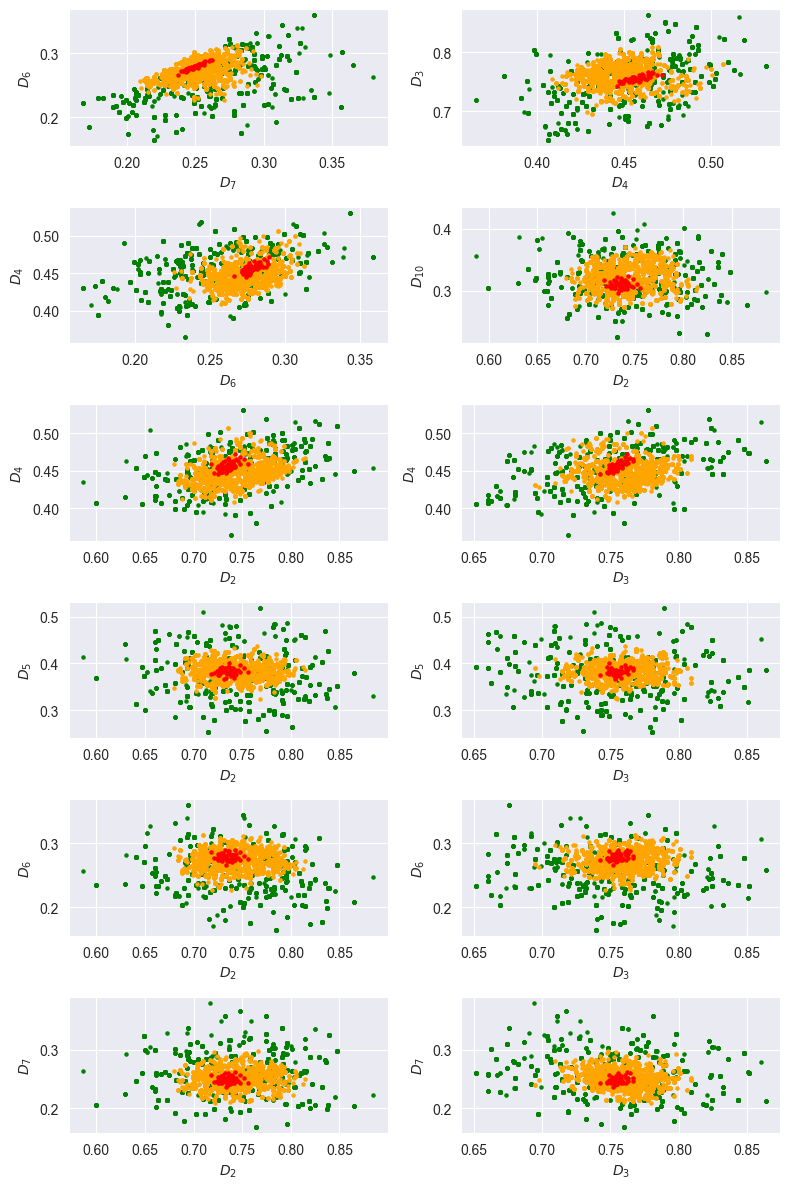

In [13]:
pairs_2_plt = [[6,5], [3,2],  [5,3], [1,9],
               [1,3], [2,3],  [1,4], [2,4],
               [1,5], [2,5],  [1,6], [2,6]]

fix, ax = plt.subplots(6,2, figsize=(8,12))
axs = ax.flatten()
for pairs, ax in zip(pairs_2_plt, axs):
    ax.scatter(Y_sim_knn[:,pairs[0]], Y_sim_knn[:,pairs[1]], 5, c='g', label='knn 0')
    ax.scatter(Y_calibrated_knn_2[:,pairs[0]], Y_calibrated_knn_2[:,pairs[1]], 5, c='orange', label='knn 2')
    ax.scatter(Y_emp[:,pairs[0]], Y_emp[:,pairs[1]], 5, c='r', label='emp')
    ax.set_xlabel(Y_latex_names[pairs[0]])
    ax.set_ylabel(Y_latex_names[pairs[1]])

plt.tight_layout()
plt.show()

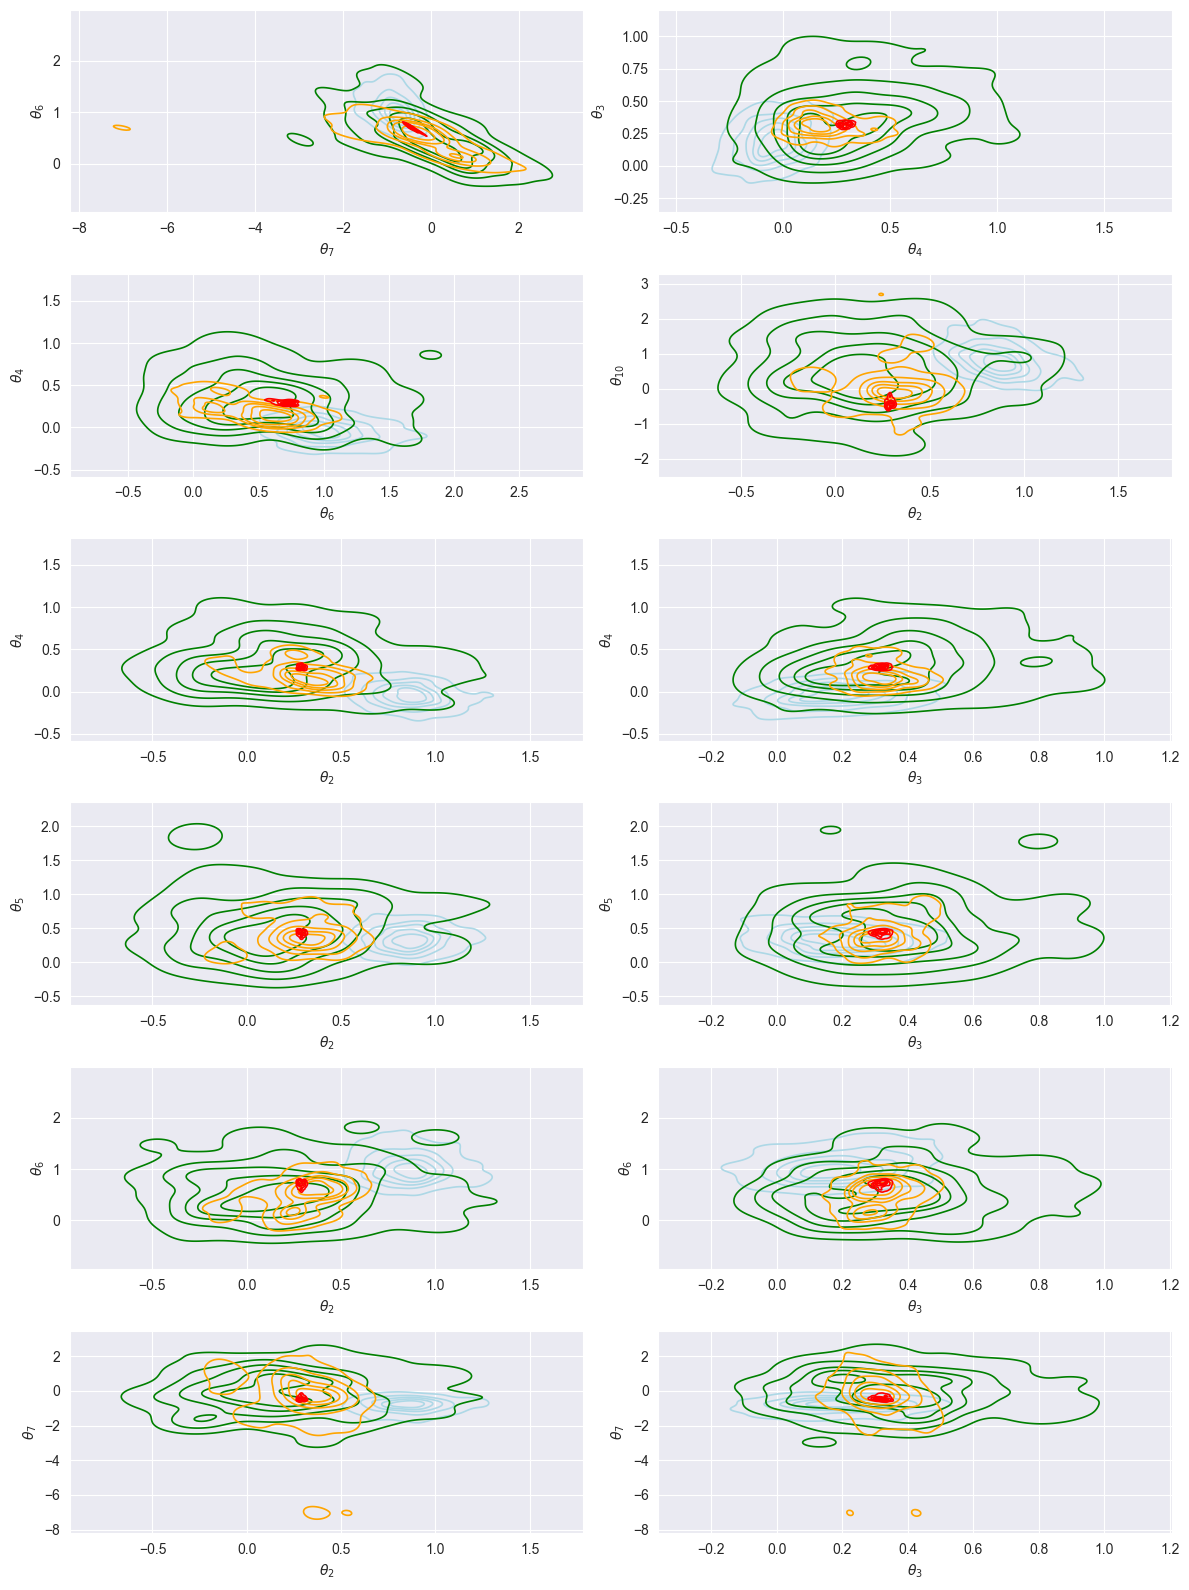

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# pairs_2_plt = [(0,1), (0,2), (1,2), ...]  # your pairs
# datasets to compare: (array, color, label)
datasets = [
    (X_normal_knn_resampled, "lightblue", "sim - knn resampled"),
    (theta_set, "green", "knn 0"),
    (theta_set_2, "orange", "knn 2"),
    (theta_tmcmc, "red", "target"),
]

fig, ax = plt.subplots(6, 2, figsize=(12, 16))
axs = ax.flatten()

for pairs, axi in zip(pairs_2_plt, axs):
    x_idx, y_idx = pairs
    for data, color, label in datasets:
        sns.kdeplot(
            x=data[:500, x_idx],
            y=data[:500, y_idx],
            ax=axi,
            levels=6,               # 4 isoprobability lines
            linewidths=1.2,
            colors=color,
            label=label,
            fill=False              # keep only contours
        )
    axi.set_xlabel(theta_latex_names[x_idx])
    axi.set_ylabel(theta_latex_names[y_idx])
    #axi.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()


In [17]:
X_standard = scaler.fit_transform(X_scaled)
sigma    = df['sigma'].to_numpy(dtype=np.float32) if 'sigma' in df.columns else None
print(f"[sim] X_scaled {X_scaled.shape} | X_phys {X_phys.shape} | Y_sim {Y_sim.shape} | sigma {None if sigma is None else sigma.shape}")

[sim] X_scaled (500000, 11) | X_phys (500000, 11) | Y_sim (500000, 10) | sigma (500000,)


In [18]:
# --------------------------- call your KNN posterior ---------------------------
# We’ll estimate in the **scaled θ space**, consistent with how the NN was trained.
simulated_data = [Y_sim, X_standard, None]     # [y, θ, ξ]; ξ not used -> None
theta_post_scaled = estimate_p_theta_knn(
    observed_data=Y_emp,   # use the complete empirical data set
    simulated_data=simulated_data,
    xi_star=None,         # no design conditioning in AIRMOD
    knn=50,               # adjust K as you like
    a_tol=0.05
)
print(f"[post] theta_post_scaled {theta_post_scaled.shape}")

# --------------------------- (optional) convert to physical units ---------------------------
theta_phys_mu = np.array(
    [3.375, 14.060, 243.75, 0.375, 0.345, 0.345,  0.028, 0.028, 3.75e7, 3.75e7, 1.31e7],
    dtype=np.float32 )

theta_post_phys = theta_post_scaled * theta_phys_mu.reshape(1, -1)

# --------------------------- save results ---------------------------
cols_scaled = [f"theta_scaled_{j+1}" for j in range(theta_post_scaled.shape[1])]
cols_phys   = [f"theta_phys_{j+1}" for j in range(theta_post_phys.shape[1])]
out_df = pd.DataFrame(theta_post_scaled, columns=cols_scaled)
for j, c in enumerate(cols_phys):
    out_df[c] = theta_post_phys[:, j]

out_df.to_csv("airmod_knn_theta_posterior.csv", index=False)
print("Saved: airmod_knn_theta_posterior.csv")

# --------------------------- quick sanity print ---------------------------
print(out_df.describe().T.loc[cols_scaled[:3]])  # first 3 θ as a glance

[post] theta_post_scaled (2500, 11)
Saved: airmod_knn_theta_posterior.csv
                 count      mean       std       min       25%       50%  \
theta_scaled_1  2500.0  0.740363  0.473348  0.008823  0.275945  0.750399   
theta_scaled_2  2500.0  0.289178  0.399634 -0.727533  0.019288  0.275958   
theta_scaled_3  2500.0  0.440834  0.222222 -0.078516  0.248650  0.452729   

                     75%       max  
theta_scaled_1  1.072343  1.728423  
theta_scaled_2  0.558325  1.218276  
theta_scaled_3  0.583227  1.099008  


In [19]:
df_knn_2plot_in = pd.DataFrame(theta_post_scaled, columns=theta_names).iloc[:5000,:5]
df_knn_2plot_in['source'] = 'KNN'
df_tmcm_2plot_in = pd.DataFrame(theta_tmcmc, columns=theta_names).iloc[:5000,:5]
df_tmcm_2plot_in['source'] = 'TMCMC'


df_knn_2plot_out = pd.DataFrame(Y_sim_knn).iloc[:2000,:5]
df_knn_2plot_out['source'] = 'KNN'
df_tmcm_2plot_out = pd.DataFrame(Y_emp).iloc[:200,:5]
df_tmcm_2plot_out['source'] = 'data'

show_input = False
if show_input:
    df_2plt = pd.concat([df_knn_2plot_in,df_tmcm_2plot_in])
else:
    df_2plt = pd.concat([df_knn_2plot_out,df_tmcm_2plot_out])